In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from cmath import nan
import pywt
import torch
import pywt
from pandarallel import pandarallel
import tqdm
from functools import partial
pandarallel.initialize(progress_bar=True)

/Users/htnu/opt/miniconda3/envs/torch/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


# Generate time sequence dataset

In [3]:
def fill_flag(sample):
    if not isinstance(sample['Flag'], str):
        col = 'Data' + str(sample['DLC'])
        sample['Flag'], sample[col] = sample[col], sample['Flag']
    return sample

In [4]:
attacks = ['DoS', 'Fuzzy', 'gear', 'RPM']
attack_id = 0
columns = ['Timestamp', 'ID', 'DLC', 'Data0', 'Data1', 'Data2', 'Data3', 'Data4',
       'Data5', 'Data6', 'Data7', 'Flag']
df = pd.read_csv('../../Data/Car-Hacking/{}_dataset.csv'.format(attacks[attack_id]), names=columns)
df = df.parallel_apply(fill_flag, axis=1)
df = df.fillna(0)
df['Flag'] = (df['Flag'] == 'T')
df['Time_scale'] = df['Timestamp'] - df.iloc[0]['Timestamp']
df

,Timestamp,ID,DLC,Data0,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Flag,Time_scale
0,1.478198e+09,0316,8,05,21,68,09,21,21,00,6f,False,0.000000
1,1.478198e+09,018f,8,fe,5b,00,00,00,3c,00,00,False,0.000209
2,1.478198e+09,0260,8,19,21,22,30,08,8e,6d,3a,False,0.000437
3,1.478198e+09,02a0,8,64,00,9a,1d,97,02,bd,00,False,0.000669
4,1.478198e+09,0329,8,40,bb,7f,14,11,20,00,14,False,0.000906
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3665766,1.478201e+09,018f,8,fe,59,00,00,00,41,00,00,False,2832.668580
3665767,1.478201e+09,0260,8,18,21,21,30,08,8f,6d,19,False,2832.668810
3665768,1.478201e+09,02a0,8,24,00,9a,1d,97,02,bd,00,False,2832.669044
3665769,1.478201e+09,0329,8,dc,b7,7f,14,11,20,00,14,False,2832.669276


In [5]:
from numpy.lib.stride_tricks import as_strided

def sliding_window(data, win=29, s=1):
    itemsize  = data.itemsize
    N = len(data)
    sliding_data = as_strided(data, shape=((N - win) // s + 1, win), strides=(itemsize*s, itemsize))
    return sliding_data

In [6]:
def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

In [17]:
sliding_label = sliding_window(df['Flag'].to_numpy(), win=29, s=4)
sliding_id = sliding_window(df['ID'].to_numpy(), win=29, s=14)
labels = np.any(sliding_label, axis=1).astype('int8')

In [18]:
# Just check whether the attack frame is consecutive within a specific time
attack_indices = np.where(labels == 1)[0]
consecutive(attack_indices)[0]

array([ 362,  363,  364, ..., 2120, 2121, 2122])

In [21]:
sliding_label[attack_indices[100]]

array([ True, False,  True, False,  True, False,  True, False,  True,
       False,  True, False,  True, False,  True,  True,  True, False,
        True, False,  True, False,  True, False,  True, False,  True,
       False,  True])

In [18]:
transform_cols = ['ID'] + ['Data'+str(x) for x in range(8)]
types = ['int16' for _ in range(9)]
for c, t in zip(transform_cols, types):
    df['transformed_'+c] = df[c].map(lambda x: int(str(x), 16))
    df['transformed_'+c] = df['transformed_'+c].astype(t)
df

,Timestamp,ID,DLC,Data0,Data1,Data2,Data3,Data4,Data5,Data6,...,Flag,transformed_ID,transformed_Data0,transformed_Data1,transformed_Data2,transformed_Data3,transformed_Data4,transformed_Data5,transformed_Data6,transformed_Data7
0,1.478191e+09,0316,8,05,22,68,09,22,20,00,...,False,790,5,34,104,9,34,32,0,117
1,1.478191e+09,018f,8,fe,3b,00,00,00,3c,00,...,False,399,254,59,0,0,0,60,0,0
2,1.478191e+09,0260,8,19,22,22,30,ff,8f,6e,...,False,608,25,34,34,48,255,143,110,63
3,1.478191e+09,02a0,8,60,00,83,1d,96,02,bd,...,False,672,96,0,131,29,150,2,189,0
4,1.478191e+09,0329,8,dc,b8,7e,14,11,20,00,...,False,809,220,184,126,20,17,32,0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4621697,1.478201e+09,018f,8,fe,59,00,00,00,41,00,...,False,399,254,89,0,0,0,65,0,0
4621698,1.478201e+09,0260,8,18,21,21,30,08,8f,6d,...,False,608,24,33,33,48,8,143,109,25
4621699,1.478201e+09,02a0,8,24,00,9a,1d,97,02,bd,...,False,672,36,0,154,29,151,2,189,0
4621700,1.478201e+09,0329,8,dc,b7,7f,14,11,20,00,...,False,809,220,183,127,20,17,32,0,20


In [20]:
feats = {}
window_size = 64
stride = 32
for c in transform_cols:
    data = df['transformed_'+c].to_numpy()
    sliding_data = sliding_window(data, win=window_size, s=stride)
    feats[c] = pd.Series(sliding_data.tolist())

sliding_label = sliding_window(df['Flag'].to_numpy(), win=window_size, s=stride)
sliding_label = np.any(sliding_label, axis=1).astype('int8')
feats['Label'] = sliding_label
feats['Label'][np.where(feats['Label'] > 0)] = attack_id + 1

pp_df = pd.DataFrame(feats)
pp_df.Label.value_counts()

0    79430
4    64997
Name: Label, dtype: int64

In [21]:
from pathlib import Path
import torch

save_dir = f'../Data/CHD_w{window_size}_s{stride}_ID_Data/time_sequence'
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)
cols = pp_df.columns
tensor_list = [torch.tensor(pp_df[c]) for c in cols]
torch.save(tensor_list, save_dir / f'{attacks[attack_id]}.pt')

# Load data from time sequence file

In [3]:
def convert_wavelet(signal, waveletname):
    N = len(signal)
    scales = np.arange(1, N + 1)
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname)
    coefficients = np.expand_dims(coefficients, axis=0)
    return coefficients

def create_wavelet_feature(sample, waveletname):
    wavelet_matrices = [convert_wavelet(signal, waveletname=waveletname) for signal in sample[:-1]]
    wavelet_features = np.concatenate(wavelet_matrices, axis=0)
    return np.expand_dims(wavelet_features, axis=0) 

In [4]:
attacks = ['DoS', 'Fuzzy', 'gear', 'RPM']
window_size = 64
stride = 32
data_dir = f'../Data/CHD_w{window_size}_s{stride}_ID_Data/'
pandarallel.initialize(progress_bar=True)
a = attacks[1]
print('Attack: ', a)
wavelet_family = 'gaus1'
# Read data time sequence
data = torch.load(f'{data_dir}/time_sequence/{a}.pt')
data = [d.numpy().tolist() for d in data]
cols = ['ID'] + [f'Data{x}' for x in range(8)] + ['Label']
df = pd.DataFrame(dict(zip(cols, data)))
# Convert wavelet
partial_wavelet_feature = partial(create_wavelet_feature, waveletname=wavelet_family)
X = df.parallel_apply(partial_wavelet_feature, axis=1)
y = df.Label
X_numpy = np.concatenate(X).astype(np.float16)
y_numpy = y.to_numpy().astype(np.uint8)
normal_indices = np.where(y_numpy == 0)
attack_indices = np.where(~(y_numpy == 0)) 
# Save normal 
save_file = f'{data_dir}/wavelet/{wavelet_family}/Normal_{a}.npz'
print('Saving to: ', save_file)
np.savez_compressed(save_file, X=X_numpy[normal_indices], y=y_numpy[normal_indices])
# Save attack
save_file = f'{data_dir}/wavelet/{wavelet_family}/{a}.npz'
print('Saving to: ', save_file)
np.savez_compressed(save_file, X=X_numpy[attack_indices], y=y_numpy[attack_indices])

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Attack:  Fuzzy


Saving to:  ../Data/CHD_w64_s32_ID_Data//wavelet/gaus1/Normal_Fuzzy.npz
Saving to:  ../Data/CHD_w64_s32_ID_Data//wavelet/gaus1/Fuzzy.npz


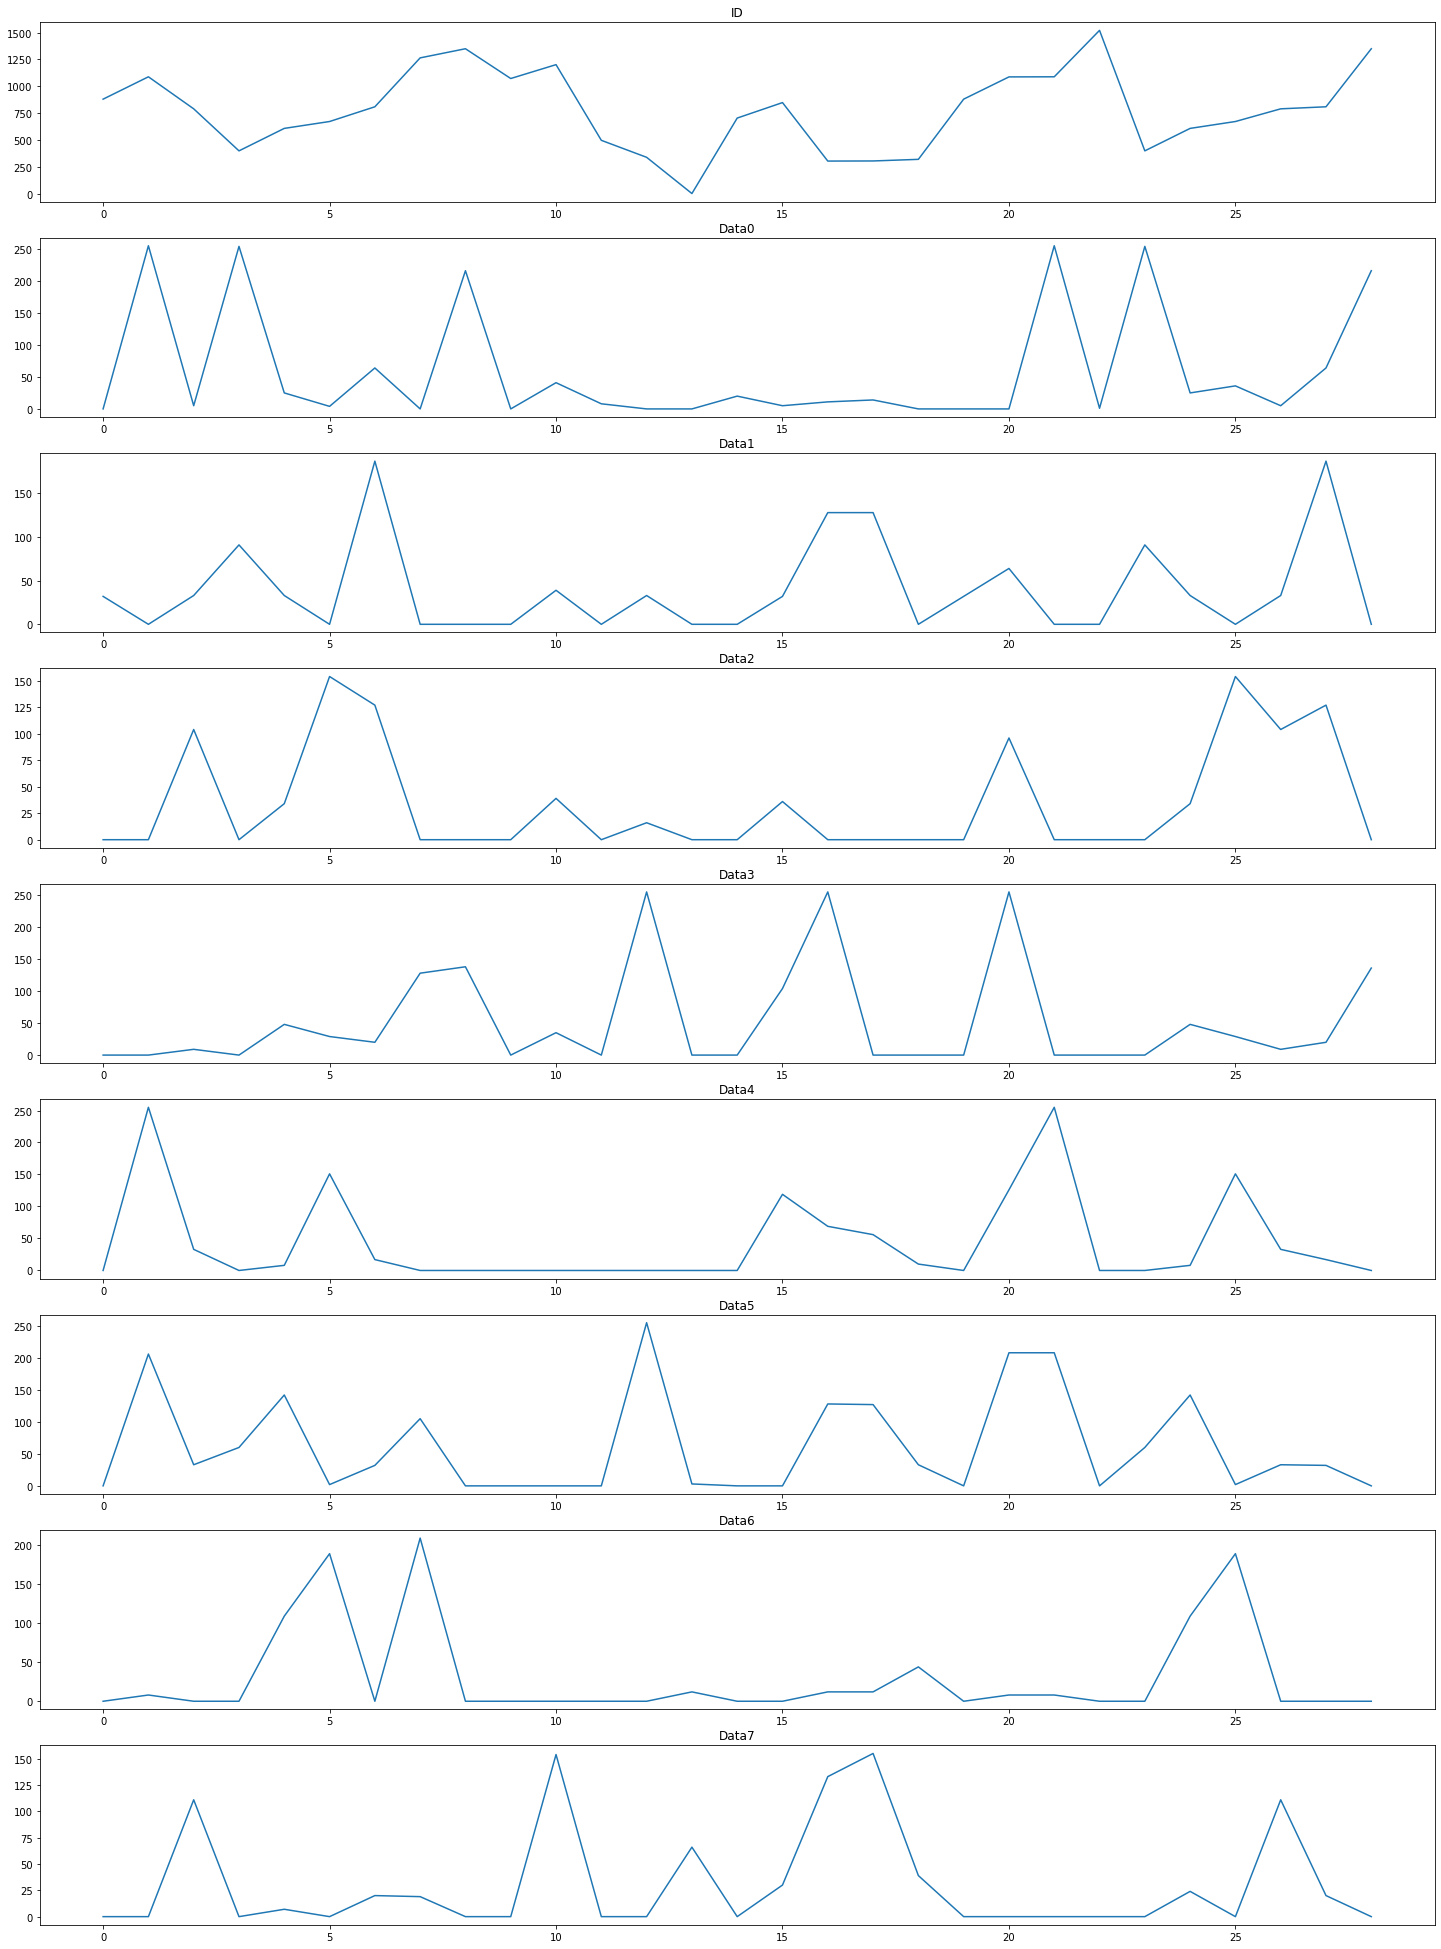

In [15]:
cols = df.columns[:-1]
fig, ax = plt.subplots(nrows=len(cols), ncols=1, figsize=(25, 35))
start = 0
window = 29
for i, name in enumerate(cols):
    data = df[name][1]
    ax[i].plot(data)
    ax[i].set_title(name)

Label: DoS


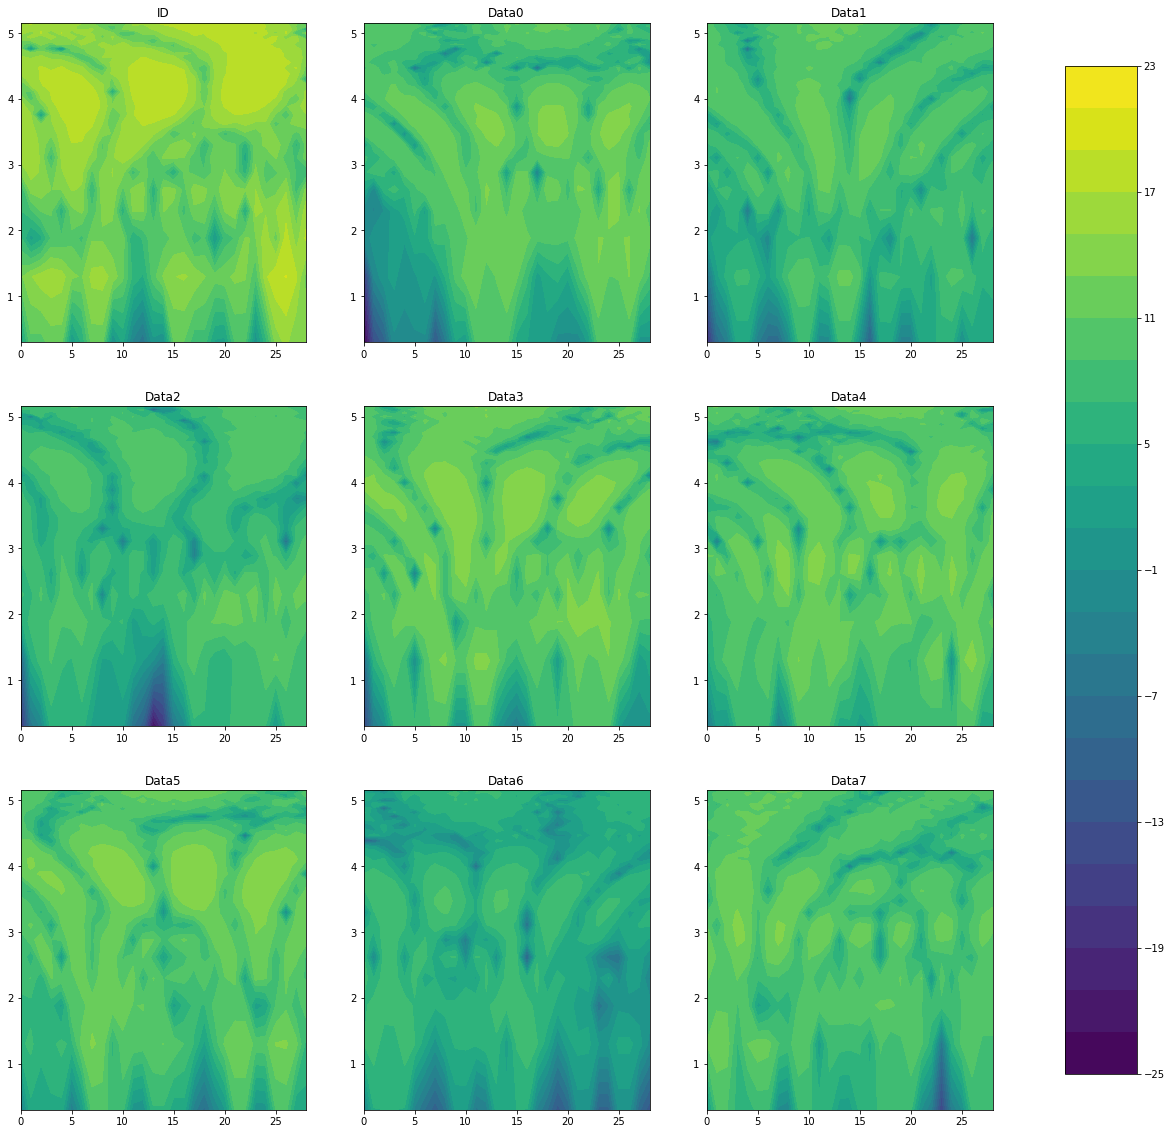

In [11]:
sample = df.iloc[113]
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))
levels = np.arange(-25, 25, 2)
print('Label: ' + (attacks[attack_id] if sample['Label'] else 'normal'))
for c, ax in zip(cols, axs.flat):
    signal = sample[c] 
    scales = np.arange(1, 30)
    waveletname = 'morl'
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname)
    power = (np.abs(coefficients))**2
    time = np.arange(29)
    periods = 1/frequencies
    im = ax.contourf(time, np.log2(periods), np.log2(power), levels)
    ax.set_title(c)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

# ax=plt.gca() #get the current axes
# PCM=ax.get_children()[2]
# plt.colorbar(PCM, ax=ax) 

# Count number of messages within time

In [19]:
# time_range in sec
def count_message_within(df, time_range=1):
    bins = np.arange(start=df.Timestamp.min(), stop=df.Timestamp.max(), step=time_range)
    split_time_interval = pd.cut(df['Timestamp'], bins, include_lowest=True)
    cnt = df.groupby(split_time_interval).count()['Timestamp'].tolist()
    return cnt 

In [20]:
cnts = count_message_within(df, time_range=0.01)

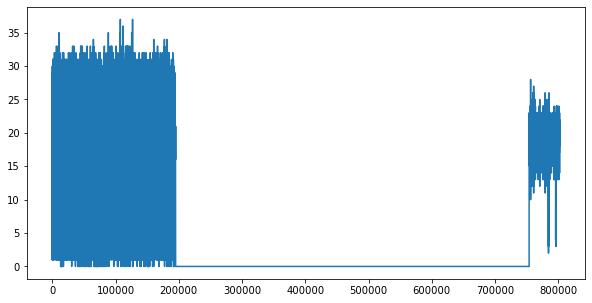

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(cnts)

In [48]:
pd.DataFrame(cnts).describe()

,0
count,801900.000000
mean,5.540746
std,9.062434
min,0.000000
25%,0.000000
50%,0.000000
75%,16.000000
max,37.000000
